[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m2lschool/tutorials2021/blob/main/generative/M2L_2020_VAE_Tutorial_Solutions.ipynb)

Contact: {fviola@google.com, marco.ciccone@me.com}

## Contents
* Enabling TPUs in colab
* Handling nested data structures using tree utilities in JAX
* Distributing computation over multiple devices using *pmap*
* Amortized variational inference (VAEs)
  * Training VAEs optimizing ELBO
  * Training $\beta$-VAEs
  * Training VAEs using constraint optimization (GECO)


# Set up your environment!

In [1]:
#@title Download and install all the missing packages required for this tutorial { display-mode: "code" }
! pip install ipdb -q
! pip install chex -q
! pip install optax -q
! pip install dm_haiku -q
! pip install tfp-nightly[jax] -q
! pip install tf-nightly -q
! pip install livelossplot -q
print("All packages installed!")

     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 266kB 13.7MB/s 
     |████████████████████████████████| 4.9MB 13.3MB/s 
     |████████████████████████████████| 400.4MB 38kB/s 
     |████████████████████████████████| 4.0MB 46.9MB/s 
     |████████████████████████████████| 471kB 53.0MB/s 
     |████████████████████████████████| 4.0MB 41.1MB/s 
     |████████████████████████████████| 12.2MB 30.5MB/s 
ERROR: tensorflow 2.4.0 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.0 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
All packages installed!


In [2]:
# @title Imports

import inspect
import os

import chex
import dill
import functools
import haiku as hk
import jax
import jax.numpy as jnp

import numpy as np
import optax as tx
import requests
from pprint import pprint

import seaborn as sns
from matplotlib import pyplot as plt
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

import tensorflow as tf
import tensorflow_probability
from tensorflow_probability.substrates import jax as tfp

sns.set(rc={"lines.linewidth": 2.8}, font_scale=2)
sns.set_style("whitegrid")

# Returns the code of the python implementation of a given funciton as a string.
get_code_as_string = lambda fn: dill.source.getsource(fn.__code__)

In [11]:
# ------------------ #
# Enable TPU support #
# ------------------ #

# This cell execution might take a while! don't worry :)
# Don't forget to select a TPU or GPU runtime environment in
# Runtime -> Change runtime type
try:
  if 'TPU_DRIVER_MODE' not in globals():
    url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
    resp = requests.post(url)
    TPU_DRIVER_MODE = 1

  # The following is required to use TPU Driver as JAX's backend.
  from jax.config import config
  config.FLAGS.jax_xla_backend = "tpu_driver"
  config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
except:
  print('TPUs not found. Enable a TPU runtime going to: '
        '"Runtime -> Change runtime type"')
devices = jax.devices()
print("Available devices:", devices)
# Should print something like
# Available devices: [TpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, host_id=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, host_id=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, host_id=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, host_id=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, host_id=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, host_id=0, coords=(1,1,0), core_on_chip=1)]

Available devices: [TpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, host_id=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, host_id=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, host_id=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, host_id=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, host_id=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, host_id=0, coords=(1,1,0), core_on_chip=1)]


# Warmup: bits and bobs

Let's take a minute to look at some cool and useful JAX functionality we will be using in this tutorial.

## How to work with nested data with `jax.tree_utils`

It is fairly common to structure data and parameters into nested formats, for example (nested) dictionaries, namedtuples, lists, dataclasses and variants thereof. For example, we might want to cleanly scope and group our model's variables by their component name into some dictionary-like format, like in Haiku, or in a Reinforcement Learning setting we might want to explicitely label the components of a rollout.

Typically in our code we don't want to assume a priori any strucuture of the containers we are manipulating, and prefer code that can transparently handle arbitrary nested structures. Luckily JAX can natively do this for us, and we only need to familiarize ourselves with its `jax.tree_util` package, and make sure that our custom objects are registered with it (not to worry, we have libraries that do this for us!).

You can find out more in the JAX `tree_util` package [documentation](https://jax.readthedocs.io/en/latest/jax.tree_util.html).

In [12]:
from collections import namedtuple 
data_container = namedtuple('data_box', 'component_a component_b')
data = dict(
    a=jnp.ones(shape=()),
    b=[jnp.ones(shape=()),
       data_container(jnp.ones(shape=()), jnp.ones(shape=()))],
    c=(jnp.ones(shape=()), jnp.ones(shape=())))
print('Structured data\n', data)

# We can use `jax.tree_map` to apply the same function to all the tensors
# contained in a nested data structure.
fn = lambda x: x * 2
output = jax.tree_map(fn, data)
print('Structure data, after {}'.format(get_code_as_string(fn)), output)

# We can also call functions with multiple structured inputs, for example
# parameters and gradients in an update step.
fn = lambda x, y, delta=0.1: x + delta * y
output = jax.tree_multimap(fn, data, data)
print('Structure data, after {}'.format(get_code_as_string(fn)), output)

# We can also 'flatten' the data to get a list of all the tensors contained in
# the nested data structure.
entries = jax.tree_leaves(data)
print('Tree leaves\n', entries)

# We can 'unflatten' flattened data to get back the original strucure if we keep
# around the original structure defintion.
entries, tree_def = jax.tree_flatten(data)  # tree_def capture the structure
data = jax.tree_unflatten(tree_def, entries)
print('Flattened data\n', entries)
print('Unflattened data\n', data)

Structured data
 {'a': DeviceArray(1., dtype=float32), 'b': [DeviceArray(1., dtype=float32), data_box(component_a=DeviceArray(1., dtype=float32), component_b=DeviceArray(1., dtype=float32))], 'c': (DeviceArray(1., dtype=float32), DeviceArray(1., dtype=float32))}
Structure data, after fn = lambda x: x * 2
 {'a': DeviceArray(2., dtype=float32), 'b': [DeviceArray(2., dtype=float32), data_box(component_a=DeviceArray(2., dtype=float32), component_b=DeviceArray(2., dtype=float32))], 'c': (DeviceArray(2., dtype=float32), DeviceArray(2., dtype=float32))}
Structure data, after fn = lambda x, y, delta=0.1: x + delta * y
 {'a': DeviceArray(1.1, dtype=float32), 'b': [DeviceArray(1.1, dtype=float32), data_box(component_a=DeviceArray(1.1, dtype=float32), component_b=DeviceArray(1.1, dtype=float32))], 'c': (DeviceArray(1.1, dtype=float32), DeviceArray(1.1, dtype=float32))}
Tree leaves
 [DeviceArray(1., dtype=float32), DeviceArray(1., dtype=float32), DeviceArray(1., dtype=float32), DeviceArray(1., dty

In [13]:
# ------------------------ #
# WARMUP OPTIONAL EXERCISE #
# ------------------------ #

# You have some batched data, structured in an unknow way and you want
# to recover a list of unbatched data, structured the same way.
# Write the code to do that using jax.tree_utils

input_data = dict(
    a=jnp.arange(3),
    b=[jnp.arange(3),
       data_container(jnp.arange(3), jnp.arange(3))],
    c=(jnp.arange(3), jnp.arange(3)))

print('Input data')
pprint(input_data)

def unbatch(data):
  flattened_data, tree_def = jax.tree_flatten(data)
  # ADD CODE BELOW 
  # -----------------------  
  split_data = [jnp.split(x, x.shape[0]) for x in flattened_data]
  unbatched_data = [jax.tree_unflatten(tree_def, x) for x in zip(*split_data)] 
  # -----------------------
  return unbatched_data

print('\nSplit data')
pprint(unbatch(input_data))

# Expected output: 
# Input data
# {'a': DeviceArray([0, 1, 2], dtype=int32),
#  'b': [DeviceArray([0, 1, 2], dtype=int32),
#        data_box(component_a=DeviceArray([0, 1, 2], dtype=int32), component_b=DeviceArray([0, 1, 2], dtype=int32))],
#  'c': (DeviceArray([0, 1, 2], dtype=int32),
#        DeviceArray([0, 1, 2], dtype=int32))}

# Split data
# [{'a': DeviceArray([0], dtype=int32),
#   'b': [DeviceArray([0], dtype=int32),
#         data_box(component_a=DeviceArray([0], dtype=int32), component_b=DeviceArray([0], dtype=int32))],
#   'c': (DeviceArray([0], dtype=int32), DeviceArray([0], dtype=int32))},
#  {'a': DeviceArray([1], dtype=int32),
#   'b': [DeviceArray([1], dtype=int32),
#         data_box(component_a=DeviceArray([1], dtype=int32), component_b=DeviceArray([1], dtype=int32))],
#   'c': (DeviceArray([1], dtype=int32), DeviceArray([1], dtype=int32))},
#  {'a': DeviceArray([2], dtype=int32),
#   'b': [DeviceArray([2], dtype=int32),
#         data_box(component_a=DeviceArray([2], dtype=int32), component_b=DeviceArray([2], dtype=int32))],
#   'c': (DeviceArray([2], dtype=int32), DeviceArray([2], dtype=int32))}]


Input data
{'a': DeviceArray([0, 1, 2], dtype=int32),
 'b': [DeviceArray([0, 1, 2], dtype=int32),
       data_box(component_a=DeviceArray([0, 1, 2], dtype=int32), component_b=DeviceArray([0, 1, 2], dtype=int32))],
 'c': (DeviceArray([0, 1, 2], dtype=int32),
       DeviceArray([0, 1, 2], dtype=int32))}

Split data
[{'a': DeviceArray([0], dtype=int32),
  'b': [DeviceArray([0], dtype=int32),
        data_box(component_a=DeviceArray([0], dtype=int32), component_b=DeviceArray([0], dtype=int32))],
  'c': (DeviceArray([0], dtype=int32), DeviceArray([0], dtype=int32))},
 {'a': DeviceArray([1], dtype=int32),
  'b': [DeviceArray([1], dtype=int32),
        data_box(component_a=DeviceArray([1], dtype=int32), component_b=DeviceArray([1], dtype=int32))],
  'c': (DeviceArray([1], dtype=int32), DeviceArray([1], dtype=int32))},
 {'a': DeviceArray([2], dtype=int32),
  'b': [DeviceArray([2], dtype=int32),
        data_box(component_a=DeviceArray([2], dtype=int32), component_b=DeviceArray([2], dtype=int32

## How to parallelize gradients computation over multiple devices using JAX.

In JAX you can use the `pmap` primitive to parallelize computation over multiple devices; using reduction methods in `jax.lax` you can also have access to values aggregated across devices during the distributed computation, giving you a lot of flexibility over what you can achieve!

For example, you can split a *large* batch over 8 TPU cores, compute partial 
gradients over the split batches and average them prior to updating
the model parameters - in parallel - across all devices.

Let's look at some example code of how this can be done.


Number of devices:
 8 

Data shape:
 (8, 1024, 2) 

Params:
 [-0.78476894  0.85644746] 

Mapped params:
 [[-0.78476894  0.85644746]
 [-0.78476894  0.85644746]
 [-0.78476894  0.85644746]
 [-0.78476894  0.85644746]
 [-0.78476894  0.85644746]
 [-0.78476894  0.85644746]
 [-0.78476894  0.85644746]
 [-0.78476894  0.85644746]] 

Averaged_grads:
 [[-3.730554 -6.125271]
 [-3.730554 -6.125271]
 [-3.730554 -6.125271]
 [-3.730554 -6.125271]
 [-3.730554 -6.125271]
 [-3.730554 -6.125271]
 [-3.730554 -6.125271]
 [-3.730554 -6.125271]] 

Mapped_grads:
 [[-3.7561762 -6.1428185]
 [-3.7707505 -6.147433 ]
 [-3.588753  -6.001064 ]
 [-3.7663689 -6.1311326]
 [-3.7870026 -6.1873107]
 [-3.6276586 -6.0731416]
 [-3.89319   -6.2363887]
 [-3.654534  -6.0828767]] 

Manually averaged_grads:
 [-3.7305543 -6.125271 ] 



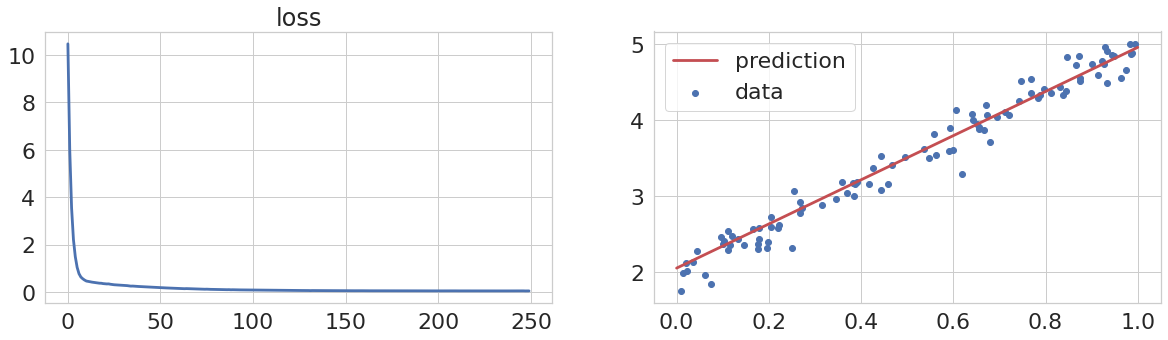

In [14]:
# ------- #
# EXAMPLE #
# ------- #

# First off, let's verify that you that in this colab you should have access to 
# multiple TPU cores.
num_dev = jax.local_device_count()
print('Number of devices:\n', num_dev, '\n')

# Let's define a simple data generation function, and an MSE loss for linear
# regression.
def get_data(prng_key, batch_size):
  x_key, noise_key = jax.random.split(prng_key, 2)
  x = jax.random.uniform(x_key, shape=(batch_size,1))
  true_model = lambda x: x * 3 + 2 
  noise = lambda key: jax.random.normal(key, shape=(batch_size, 1)) * 0.2
  return jnp.concatenate([x, true_model(x) + noise(noise_key)], axis=1)

def loss_fn(params, data):
  prediction = params[0] * data[:, 0] + params[1]
  target = data[:, 1]
  return jnp.mean((prediction - target) ** 2)

batch_size = 1024
prng_key = jax.random.PRNGKey(0)
data = get_data(prng_key, batch_size)
params = jax.random.normal(prng_key, shape=(2,))

# On a single core we can compute the gradients over a minibatch with:
grad_fn = jax.grad(loss_fn)
gradients = grad_fn(params, data)
# and update the parameters using any update rule, like those you can find in
# the optax package. 

# We now want to take advantage of the the multiple core made available to us. 
# To do so, we batch computation _over cores_.

# We format the data and batch it twice, over cores and per-device core: 
data = get_data(prng_key, batch_size * num_dev)
data = jnp.reshape(data, (num_dev, batch_size) + data.shape[1:])
# Note that the leading dimension is now the number of cores!
print('Data shape:\n', data.shape, '\n')

# We provide each core with a copy of the parameters. Given an instance of the 
# params we can use JAX's broadcasting utility to achieve this.
broadcast = lambda params: jnp.broadcast_to(params, (num_dev,) + params.shape)
mapped_params = broadcast(params)
# All the parameters copies are synced at the start of the model fitting; since
# the udpates to the params will be the same, params will stay synced during
# optimization.
print('Params:\n', params, '\n')
print('Mapped params:\n', mapped_params, '\n')

# We then pmap the gradient fn, averaging the gradients computed across devices
# using the pmap primitive and the jax.lax.pmean function.
def get_averaged_grads(params, data):
  grads = grad_fn(params, data)
  grads = jax.lax.pmean(grads, axis_name='i')
  return grads
get_averaged_grads = jax.pmap(
    get_averaged_grads, axis_name='i', devices=jax.devices())
averaged_grads = get_averaged_grads(mapped_params, data)
print('Averaged_grads:\n', averaged_grads, '\n')

# Note that this is equivalent to mapping the gradient function and manually
# averaging the result!
get_mapped_grads = jax.pmap(grad_fn, axis_name='i', devices=jax.devices())
mapped_grads = get_mapped_grads(mapped_params, data)
print('Mapped_grads:\n', mapped_grads, '\n')
print('Manually averaged_grads:\n', jnp.mean(mapped_grads, axis=0), '\n')

# Of course we can pmap in one step, cleanly, much more complicated logic.
# For example, the whole update step:
optimizer = tx.sgd(1e-1)
def update(params, opt_state, data):  
  loss, grads = jax.value_and_grad(loss_fn)(params, data)
  grads = jax.lax.pmean(grads, axis_name='i')
  raw_updates, opt_state = optimizer.update(grads, opt_state)
  params = tx.apply_updates(params, raw_updates)
  return params, opt_state, loss
# Note that pmap also compiles the function to XLA, akin to JIT!
update = jax.pmap(update, axis_name='i', devices=jax.devices())
opt_state = jax.tree_map(broadcast, optimizer.init(params))

losses = []
for _ in range(250):
  prng_key, data_key = jax.random.split(prng_key)
  data = get_data(prng_key, batch_size * num_dev)
  data = jnp.reshape(data, (num_dev, batch_size) + data.shape[1:])
  mapped_params, opt_state, loss = update(mapped_params, opt_state, data)
  losses.append(jnp.mean(loss))
  
sz = 5; plt.figure(figsize=(4*sz,sz))
plt.subplot(121)
plt.plot(losses)
plt.title('loss')
plt.subplot(122)
data = get_data(prng_key, 100)
plt.scatter(data[:,0], data[:,1], label='data')
plt.plot(
    [0, 1],
    [mapped_params[0, 1], mapped_params[0, 0] + mapped_params[0, 1]],
    'r', label='prediction')
plt.legend();

# Get the data

In this tutorial we will use the MNIST and Fashion MNIST datasets (and variations thereof). 
We can use TensorFlow data to download the data from the cloud.

In [15]:
import tensorflow_datasets as tfds
mnist = tfds.load("mnist")
fashion_mnist = tfds.load("fashion_mnist")

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteXJS4IJ/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteXJS4IJ/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


[Chex](https://github.com/deepmind/chex) is a library of utilities for helping to write reliable JAX code.

Within `chex` you will find a `dataclass` object definition, which will automatically register new class instances into JAX, so you can easily apply JAX's tree utilities out of the box. We will use it to define a labelled data object type.

In [16]:
@chex.dataclass
class ContextualData(): 
  target: chex.Array
  context: chex.Array

In [17]:
# Here we provide some utilities for experiment and data visualization.

def gallery(array, ncols=None):
  """Rearrange an array of images into a tiled layout."""
  nindex, height, width, num_channels = array.shape  
  if ncols is None:
    ncols = int(np.sqrt(nindex))    
  nrows = int(np.ceil(nindex/ncols))  
  pad = np.zeros((nrows*ncols-nindex, height, width, num_channels))
  array = np.concatenate([array, pad], axis=0)
  result = (array.reshape(nrows, ncols, height, width, num_channels)
            .swapaxes(1,2)
            .reshape(height*nrows, width*ncols, num_channels))
  return result

def imshow(x, title=''):
  """Shorthand for imshow."""
  plt.imshow(x[..., 0], cmap='gist_yarg', interpolation=None)
  plt.axis('off')
  plt.title(title)

def custom_after_subplot(ax: plt.Axes, group_name: str, x_label: str):
  """Disable Legend in LiveLossPlot (interactive Matplotlib)"""
  ax.set_title(group_name)
  ax.set_xlabel(x_label)
  ax.legend().set_visible(False)

# The datasets

In this tuturial we will train _conditional_ models.
As such, and as suggested by the `ContextualData` defintion, the dataset will provide targets and contexts. We will use two types of context, depending on the dataset.

- **Simple**: for FashionMNIST the context will be the object class label, in one-hot format. 
- **Hard**: for MNIST digits we will make things a bit more interesting: the user will specify a simple function, mapping tuples of integers in the range `[0,9]` to an integer in `[0, 9]`, for example:
```
lambda i, j: (i + j) % 10
```
The context will be a tuple of images from MNIST whose labels will match the context integers, and the target will be an MNIST image of the corresponging
output label. Hance, the result will be a dataset whose conditional context is potentially very rich and challenging to capture.

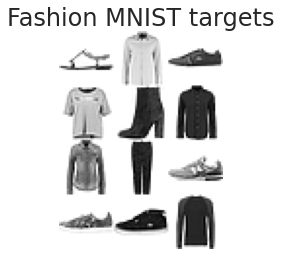

In [18]:
# --------------------------------- #
# SIMPLE context dataset generation #
# --------------------------------- #

def get_fashion_mnist(batch_size, data_split='train', seed=1, conditional=True):
  def _preprocess(sample):
    image = tf.cast(sample["image"], tf.float32) / 255.0
    context = tf.one_hot(sample["label"], 10)    
    # We can optionally make context constant, effectively making the dataset
    # unconditional. This can be useful for debuggin purposes.
    if not conditional:      
      context *= 0
    return ContextualData(target=image, context=context)
    
  ds = fashion_mnist[data_split]
  ds = ds.map(map_func=_preprocess, 
              num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds = ds.cache()
  ds = ds.shuffle(100000, seed=seed).repeat().batch(batch_size)
  return iter(tfds.as_numpy(ds))

# Visualize a sample of the data
ds = next(get_fashion_mnist(batch_size=12))
d = gallery(ds.target)
imshow(d, title='Fashion MNIST targets')

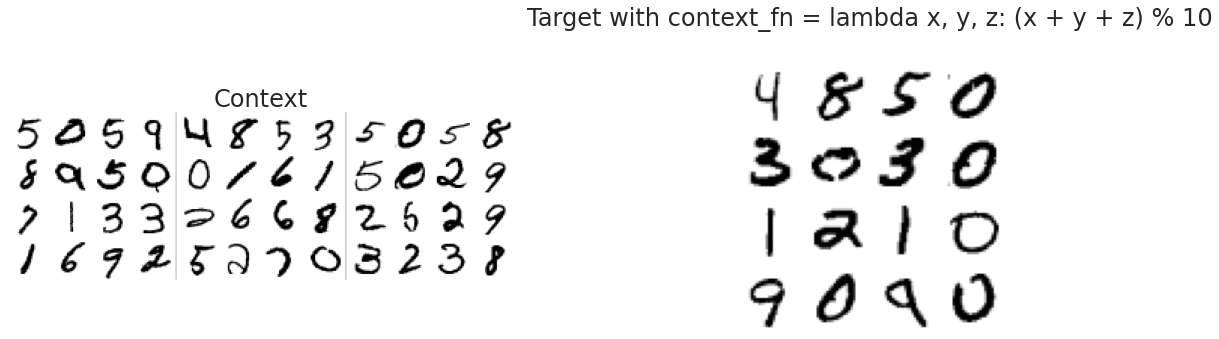

In [19]:
# ------------------------------- #
# HARD context dataset generation #
# ------------------------------- #

def get_raw_data(data_split='train'):
  def _preprocess(sample):
    image = tf.cast(sample["image"], tf.float32) / 255.0
    id = sample["label"]
    return image, id
 
  ds = mnist[data_split]
  ds = ds.map(map_func=_preprocess, 
              num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds = ds.cache()
  ds = ds.shuffle(100000, seed=0).batch(2048)
  images, labels = next(iter(tfds.as_numpy(ds)))

  data_by_label = []
  for i in range(10):
    data_by_label.append(images[labels==i])
  min_num = min([d.shape[0] for d in data_by_label])
  return np.stack([d[:min_num] for d in data_by_label])


def get_mnist_digits(batch_size,
                     fn=None,
                     data_split='train',
                     max_num_examplars=None):
  """Instantiates a data generation function implementing the input fn in mnist.

  Args:
    batch_size: (int) batch size of the returned data
    fn: (python function) default sum of two digits modulo 10, function from n
        digits to a digit. The generator will return a batch of n + 1 digit
        images whose labels correspont to inputs and output of the function.
    data_split: (string) default 'train', crop of mnist to use for the data.
    max_num_examplars: (int) maximum number of exemplars to be used - even when
        not specified all digits will be represented by the same number of
        exemplars.

  Returns:
    Function of JAX PRNG returning samples from mnist related to each other via
    the user input fn function.
  """
  raw_data = get_raw_data(data_split)
  sz = raw_data.shape[1]
  if max_num_examplars is not None:
    sz = min(max_num_examplars, sz)

  if fn is None:
    # Examples
    # fn = lambda i, j: (i + j) % 10
    # fn = lambda i: (i + 1) % 10
    fn = lambda i: (i + 1) % 10

  num_inputs = len(inspect.signature(fn).parameters)
  def data_fn(prng):
    digit_prng, sample_prng = jax.random.split(prng, 2)
    digit_indices = jax.random.randint(
        digit_prng, shape=[batch_size, num_inputs], minval=0, maxval=10)
    digit_indices = digit_indices.split(num_inputs, axis=1)
    digit_indices += [fn(*digit_indices)]

    sample_indices = jax.random.randint(
        sample_prng, shape=[batch_size, num_inputs+1], minval=0, maxval=sz)
    sample_indices = sample_indices.split(num_inputs + 1, axis=1)
    samples = [raw_data[i[..., 0], j[..., 0], ...]
               for i, j in zip(digit_indices, sample_indices)]
    return samples

  def generator(key=None):
    if key is None:
      key = jax.random.PRNGKey(0)
    while True:
      key, sample_key = jax.random.split(key)
      data = data_fn(sample_key)
      yield ContextualData(target=data[-1], context=data[:-1])

  return generator

def tile_context(context, filler_value=.2):
  entries = [gallery(d) for d in data.context]
  entry_shape = entries[0].shape
  separator = np.full((entry_shape[0], 1, 1), filler_value) 
  entries = [
    np.concatenate([e, separator], axis=1) for e in entries[:-1]] + entries[-1:] 
  return np.concatenate(entries, axis=1)

# Visualize samples of target with hard context function 
context_fn = lambda x, y, z: (x + y + z) % 10
data = next(get_mnist_digits(fn=context_fn, batch_size=16)())
sz = 5
plt.figure(figsize=(4 * sz, sz))
plt.subplot(122)
imshow(gallery(data.target),
       'Target with ' + get_code_as_string(context_fn))
plt.subplot(121)
imshow(tile_context(data.context) , 'Context')

For convenience, we define a dataset constructor function taking a `hard` flag switching between the MNIST and Fashion MNIST datasets, as well a dummy dataset
constructor that we will use for the purpose of retrieving shape information at graph construction time.

In [20]:
def get_dataset(batch_size, num_dev, hard=False, data_split='train'):
  # Instantiates the dataset adjusting the batch size to support training on 
  # multiple devices.
  if hard: 
    dataset = get_mnist_digits(
        batch_size=batch_size*num_dev, 
        data_split=data_split)()
  else:
    dataset = get_fashion_mnist(
        batch_size=batch_size*num_dev, 
        data_split=data_split)
  return dataset


def get_dummy_data(hard=False):
  # Returns an instance of the data to gather shape info.
  return next(get_dataset(batch_size=1, num_dev=1, hard=hard))

# Amortized variational inference (VAEs)

Consider a joint distribution $p(x, z)$ over a set of latent variables $z \in \mathcal{Z}$ and observed variable $x \in \mathcal{X}$ (for instance, the images of our dataset).

Making inference over the observed variable $x$ involves computing the posterior distribution $p(z|x) = p(x,z)/p(x)$ which is often intractable to compute, as the _marginal likelihood_ $p(x) = \int_z p(x, z)dz$ requires integrating over a potentially exponential number of configurations of $z$. 

**Variational Inference (VI)** can be used to approximate the posterior $p(z|x)$ in a tractable fashion. VI casts the problem of computing the posterior as an optimization problem introducing a family of tractable (simpler) distributions $\mathcal{Q}$ parametrized by $\lambda$. The objective is to find the best approximation of the true posterior $q_{\lambda^*} \in \mathcal{Q}$ that minimizes the Kullback-Leibler (KL) divergence with the exact prosterior: 
$$
q_{\lambda^*}(z) = \underset{q_{\lambda}}{arg min} \ \ D_{KL}(q_{\lambda}(z) || p(z|x))
$$

$q_{\lambda^*}(z)$ can serve as a proxy for the true posterior distribution. Note that the solution depends on the speciﬁc value of the observed (evidence) variables $x_i$ we are conditioning on, so computing the posterior requires solving an optimization problem for each sample independently.

In this tutorial, we use a much more efficient approach. Rather than solving an optimization process per data point, we can **amortize the cost of inference** by leveraging the power of function approximation and learn a deterministic mapping to predict the distributional variables as a function of $x$. Specifically, the posterior parameters for $x_i$ will be the output of a *learned* function $f_\theta(x_i)$, where $\theta$ are parameters shared across all data points.

<!-- Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} \log p_{\theta}(x|z)  - \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z))
\end{equation} -->

For more information, see: 
  * [Kingma and Welling, (2013), Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)
  * [Kingma and Welling, (2019), An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691)

# Implement and train a (Conditional) Variational AutoEncoder

Variational AutoEncoders (VAEs) are a powerful class of deep generative models with latent variables, comprising of three main components: an encoder, a decoder and a prior.  

The encoder, also called *inference* or *recognition model*, computes the approximate posterior distribution $q_{\phi}(z|x)$ of a given sample conditioned on $x$, while the decoder, or *generative model* reconstructs the sample starting from the latent variables $z$. In the conditional setting, the encoder and decoder will potentially also receive an additional conditioning input that we will refer to as _context_.

When we have a unconditional generative model, we generally don't have control over the specific outputs produced by the model, and the generated samples could be anything depending on the sampled latent variable. Perhaps, a more useful generative process should allow one to influence specific characteristics of the samples to generate, for instance, based on a context variable $c$, e.g. a label or category. For this reason, in this tutorial, we focus on Conditional VAEs (CVAEs) where both the encoder and the decoder are conditioned on a context variable $c$.

The main components of our model will be: 

* $P^*$ is the true data distribution. We have some samples from this in the form of a dataset.
* $p(z)$ is a *prior* distribution over the latent space. In general the prior is simply $\mathcal{N}(0, 1)$ but in our case we will *learn* a conditional prior distribution $p(z|c)$ based on the context.
* $E(x, c)$ the encoder outputs distributions over the latent space $Z$, not just elements of it. The produced distribution is denoted $q_\phi(z|x, c)$ and is the (approximate) *posterior* distribution.
* $D(z, c)$ the decoder may be stochastic again, modeling the output distribution $p_\theta(x|z, c)$.

Now we go over the reconstruction and sampling process and finally motivate the losses used to train VAEs in this tutorial.

### Reconstruction
The process for reconstruction is:

1. Take $x, c \sim P^*$.
2. Encode it $E_\phi(x|c)$, yielding $q_\phi(z|x, c)$.
3. Sample a latent $z \sim q_\phi(z|x, c)$.
4. Decode the latent $p_\theta(\hat{x}|z, c) = D_\theta(z, c)$.
5. Sample a reconstruction: $\hat{x} \sim p_\theta(\hat{x}|z, c)$.

The prior has not showed up here, it plays a role in sampling.

<center>
<img src="https://drive.google.com/uc?id=1ENXCf3UkaGKy9sAi98w_cqafAb-UBRMw" width="800" alt="Illustration of conditional VAE reconstruction and sampling" />
<figcaption>Illustration of the conditional VAE architecture. <br> Credits: <a href="https://ijdykeman.github.io/ml/2016/12/21/cvae.html"> https://ijdykeman.github.io/ml/2016/12/21/cvae.html</a></figcaption>
</center>

### Sampling
The sampling process is:

1. Given a context $c$, sample a latent $z \sim p(z|c)$ from the conditional prior.
2. Decode the latent $p_\theta(x|z, c) = D_\theta(z, c)$.
3. Sample a reconstruction: $x \sim p_\theta(x|z, c)$.

In practice we usually use simple, parametrizable distributions in the encoder and decoder. More specifically:

**Encoder**
Each latent dimension is a (univariate) gaussian, parametrized by mean and standard deviation. Note, this is the same as a multivariate guassian over the latent space with a diagional covariance matrix.

**Decoder**
We will quantize the pixels to 0 and 1, which allows us to use a Bernoulli distribution per pixel to model it. Though for visualizations we will continue to use grayscale values.


## The Loss

We use maximum likelihood for training, that is, ideally we would like to maximize:

$$\mathbb{E}_{x,c \sim P^*}\log p_{\theta}(x|c).$$

Note that $p_{\theta}(x|c)$ is the marginal probability distribution $p_{\theta}(x|c) = \int p_\theta(x, z|c) dz$. We can rewrite this in familiar terms as $\int p_\theta(x|z,c) p(z|c) dz$. However, computing (and maximizing) the above marginal is computationally infeasible.

Instead, we can show

$$\log p_{\theta}(x|c) \ge \mathbb{E}_{z \sim q(z|x,c)} \big[\log p_\theta(x | z,c)\big] - \mathbb{KL}\big(q_\phi(z | x,c) || p(z|c)\big).$$

This right hand side is called the evidence lower bound (ELBO). Broadly speaking the term variational methods, like variational inference, refers to this technique of using an approximate posterior distribution and the ELBO; this is where Variational Autoencoder gets its name from too.

In order to try to maximize the likelihood, we maximize the ELBO instead. Recall from the lecture that under some conditions (that are not going to apply to us) the inequality is actually an equality. This yield the following loss used with Variational AutoEncoders:

<font size=4>
<br>
<!-- $$ \mathcal{L}(X, z) = \mathbb{E}\big[\log P(X|z)\big] - D_{KL}\big[Q(z|X) \big|\big| P(z)\big].$$ -->

$$ \mathcal{L}(x|c) = - \Big( \mathbb{E}_{z \sim q(z|x, c)} \big[\log p_\theta(x | z, c)\big] - \mathbb{KL}\big(q_\phi(z | x, c) || p(z|c)\big) \Big).$$
</font>

Observe that:
* The first term encourages the model to reconstruct the input faithfully. This part is similar to the Vanilla AutoEncoder.
* The second term can be seen as a *regularization term* of the encoder towards the prior.
* Encoder, Decoder and Prior are conditioned on the context $c$. Removing the conditioning corresponds to recovering the original VAE formulation.

(The formula contains an expectation; in practice that would be approximated with one or more samples.)

## Implementation
We start by defining the main VAE object class.

We want to decouple its interface from how its components are defined; for example at this point we don't really care if we are using neural networks to implement the mapping from inputs to posterior.

Some of the implementation will have to be `haiku` specific, but we will make an effort to restrict these details into the initialization functions. 



In [21]:
def _transform(component):
  return hk.without_apply_rng(hk.transform(component))

# Sum-reduce on all dimensions but batch size
_batch_sum = jax.vmap(jnp.sum) 


class VAE():
  """A (conditional) Variational Autoencoder.
  
  The class expects at construction time haiku modules implementing the
  conditional {encoder, decoder, prior}, as well as context projector module.
  
  The encoder, decoder and prior use the output of the context projector
  together with their other inputs to define distributions (posterior, output
  and conditional prior respectively), implemented as tfp.distributions.

  The context projector is used to map a potentially nested context to a single
  condition tensor.
  """

  def __init__(self, *, encoder, decoder, prior, context_projector):
    self._encoder = _transform(encoder)
    self._decoder = _transform(decoder)
    self._prior = _transform(prior)
    self._context_projector = _transform(context_projector)

  def init_params(self, prng, data):
    prng_encoder, prng_decoder, prng_prior, prng_proj = jax.random.split(
        prng, 4)
    
    # Initialize the context mapping.
    # ADD CODE BELOW 
    # -----------------------
    context_projector_params = self._context_projector.init(
        prng_proj, data.context)
    projected_context = self._context_projector.apply(
        context_projector_params, data.context)
    # -----------------------

    # Initialize the conditional prior.
    # ADD CODE BELOW 
    # -----------------------
    prior_params = self._prior.init(prng_prior, projected_context)
    z = self._prior.apply(prior_params, projected_context).sample(
        seed=prng_prior) 
    # -----------------------

    # Initialize the encoder.
    # ADD CODE BELOW 
    # -----------------------
    encoder_params = self._encoder.init(
        prng_encoder, data.target, projected_context)
    # -----------------------

    # Initialize the decoder.
    # ADD CODE BELOW 
    # -----------------------
    decoder_params =  self._decoder.init(prng_decoder, z, projected_context)
    # -----------------------

    # Merge all the parameters into a single data structure.
    params = hk.data_structures.merge(
        context_projector_params, prior_params, encoder_params, decoder_params)
    return params
    
  def sample(self, params, prng, context, mean=True):
    prior_prng, decoder_prng = jax.random.split(prng)
    # Map the context.
    # ADD CODE BELOW 
    # -----------------------  
    projected_context = self._context_projector.apply(params, context)
    # -----------------------

    # Get the conditional prior distribution, and take a sample from it.
    # ADD CODE BELOW 
    # -----------------------
    conditional_prior = self._prior.apply(params, projected_context)
    z = conditional_prior.sample(seed=prior_prng)
    # -----------------------

    # Get the conditional output distribution.
    # ADD CODE BELOW 
    # -----------------------
    output_distribution = self._decoder.apply(params, z, projected_context)
    # -----------------------
    if mean:
      return output_distribution.mean()
    else:
      return output_distribution.sample(seed=decoder_prng)

  def sample_prior(self, params, prng, context):
    projected_context = self._context_projector.apply(params, context)
    conditional_prior = self._prior.apply(params, projected_context)
    return conditional_prior.sample(seed=prng)

  def decode(self, params, prng, z, context, mean=True):
    projected_context = self._context_projector.apply(params, context)
    output_distribution = self._decoder.apply(params, z, projected_context)
    if mean:
      return output_distribution.mean()
    else:
      return output_distribution.sample(seed=prng)

  def reconstruct(self, params, prng, x, context, mean=True):
    posterior_prng, decoder_prng = jax.random.split(prng)
    # Map the context.
    # ADD CODE BELOW 
    # -----------------------    
    projected_context = self._context_projector.apply(params, context)
    # -----------------------
    
    # Get the conditional posterior distribution p(z|x, context), and sample
    # from it.
    # ADD CODE BELOW
    # -----------------------
    posterior = self._encoder.apply(params, x, projected_context)
    z = posterior.sample(seed=posterior_prng)
    # -----------------------

    # Get the conditional output distribution. 
    # ADD CODE BELOW
    # -----------------------
    output_distribution = self._decoder.apply(params, z, projected_context)
    # -----------------------
    if mean:
      return output_distribution.mean()
    else:
      return output_distribution.sample(seed=decoder_prng)

  def stochastic_elbo(self, params, prng, x, context):
    """ELBO = log_p(x) - KL(q(z|x) || p(z))."""
    projected_context = self._context_projector.apply(params, context)    
    z, kl = self._z_and_kl(params, prng, x, projected_context)
    output_distribution = self._decoder.apply(params, z, projected_context)
    # Sum reduce over signal domain (but not over batch!)
    log_p_x = _batch_sum(output_distribution.log_prob(x))
    elbo = log_p_x - kl
    # Assemble all the stats that we want to log in an extra output dictionary.
    extra_outputs = dict(kl=kl, log_p=log_p_x, elbo=elbo)
    return elbo, extra_outputs

  def kl(self, params, prng, x, context):
    projected_context = self._context_projector.apply(params, context)
    _, kl = self._z_and_kl(params, prng, x, projected_context)
    return kl

  def _z_and_kl(self, params, prng, x, projected_context):
    """Sample z and compute KL(q(z|x) || p(z)) = log_p(q(z|x)) - log_p(p(x))."""

    # Get the conditional prior, given the pre-projected context
    # ADD CODE BELOW
    # -----------------------
    prior = self._prior.apply(params, projected_context)
    # -----------------------
    
    # Get the conditional posterior distribution p(z|x, context), and sample
    # from it.  
    # ADD CODE BELOW
    # -----------------------
    posterior = self._encoder.apply(params, x, projected_context)
    z = posterior.sample(seed=prng)
    # -----------------------

    # Compute the posterior log probability for the sampled z.
    # Note _batch_sum: what is this doing?
    log_q_z = _batch_sum(posterior.log_prob(z))
    
    # Compute prior log probability for the sampled z.
    # ADD CODE BELOW
    # -----------------------
    log_p_z = _batch_sum(prior.log_prob(z))
    # -----------------------

    # Compute the KL (see formula)
    # ADD CODE BELOW
    # -----------------------
    kl = log_q_z - log_p_z
    # -----------------------
    return z, kl


Here we define all the utilities we will need to implement Haiku modules for the prior, encoder and decoder required to instantiate a VAE.

In [22]:
def _make_positive(x):
  """Transforms elementwise unconstrained inputs into positive outputs."""
  # The offset is such that the output will be equal to 1 whenever the input is
  # equal to 0.
  offset = jnp.log(jnp.exp(1.) - 1.)
  return jax.nn.softplus(x + offset)
  

class DiagonalNormal(tfp.distributions.Normal):
  """Normal distribution with diagonal covariance."""

  def __init__(self, params, name='diagonal_normal'):
    if params.shape[-1] != 2:
      raise ValueError(
          f'The last dimension of `params` must be 2, got {params.shape[-1]}.')
    super().__init__(
        loc=params[..., 0], scale=_make_positive(params[..., 1]), name=name)


class ConditionalPrior(hk.Module):
  """A prior distribution whose parameters are computed by a conditioner."""

  def __init__(self, map_ctor, distribution, name='prior_net'):
    super().__init__(name=name)  
    # This function will map: (bs,) + context shape --> (bs, num_latents, 2)
    self._map = map_ctor()
    self._distribution = distribution

  def __call__(self, context):
    return self._distribution(self._map(context))


class ConditionalEncoder(hk.Module):
  """A posterior distribution whose parameters are computed by a conditioner."""

  def __init__(self, map_ctor, distribution, name='posterior_net'):
    super().__init__(name=name)
    # This function will map inputs to the to posterior distribution parameters.
    self._map = map_ctor()  
    self._distribution = distribution

  def __call__(self, x, context): 
    # We assume that x is an image and the context is flat.   
    chex.assert_rank(x, 4)
    chex.assert_rank(context, 2)     
    
    # Tile the context in order to be concatenated to the input tensor x.
    # ADD CODE BELOW 
    # -----------------------
    bs, height, width, _ = x.shape
    context = jnp.tile(
        jnp.reshape(context, [bs, 1, 1, -1]), [1, height, width, 1])
    x_and_context = jnp.concatenate([x, context], axis=-1)
    # -----------------------

    # Compute the posterior q(z|x, context) 
    return self._distribution(self._map(x_and_context))


class ConditionalDecoder(hk.Module):
  """An output distribution whose parameters are computed by a conditioner."""

  def __init__(self, map_ctor, distribution, name='output_net'):
    super().__init__(name=name)
    # This function will map (z, context) to the to output distribution
    # parameters.
    self._map = map_ctor()
    self._distribution = distribution

  def __call__(self, z, context):
    chex.assert_equal_shape_prefix([z, context], -1)
    # Concatenate the context to the latents 
    # ADD CODE BELOW 
    # -------------------------------------------------------------
    z_and_context = jnp.concatenate([z, context], axis=-1)
    # -------------------------------------------------------------
    return self._distribution(self._map(z_and_context))



Here we define how to assemble the VAE.

In [23]:
# -- Flat model 
def get_model(num_latents=50, num_hiddens=500, data_shape=[28, 28, 1]):
  """Creates a fully-connected VAE model."""

  def _build_map_to_latent_dist_params_net():
    return hk.Sequential([
        hk.Flatten(),
        hk.nets.MLP([num_hiddens, num_hiddens, num_latents * 2]),
        hk.Reshape([num_latents, 2]),
    ])

  def encoder_fn(*args, **kwargs):
    return ConditionalEncoder(
        map_ctor=_build_map_to_latent_dist_params_net,
        distribution=DiagonalNormal)(*args, **kwargs)
  
  def prior_fn(*args, **kwargs):
    return ConditionalPrior(
        map_ctor=_build_map_to_latent_dist_params_net,
        distribution=DiagonalNormal)(*args, **kwargs)

  def _build_map_to_output_dist_params_net():
    return hk.Sequential([
        hk.Flatten(),
        hk.nets.MLP([num_hiddens, num_hiddens, np.prod(data_shape)]),
        hk.Reshape(data_shape),
    ])

  def decoder_fn(*args, **kwargs):
    return ConditionalDecoder(
        map_ctor=_build_map_to_output_dist_params_net,
        distribution=tfp.distributions.Bernoulli)(*args, **kwargs)  
    
  def _concatenate(tensors):
    proj = hk.nets.MLP([num_hiddens, num_latents])
    data = []
    for x in jax.tree_leaves(tensors):
      if x.ndim > 2:
        x = proj(hk.Flatten()(x))
      # Note: this is not commutative!
      # What could we do to make this projection commutative?
      data.append(x)
    data = jnp.concatenate(data, axis=-1)
    return data

  def proj_fn(*args):
    """Maps context inputs to conditioning tensor."""
    return hk.to_module(_concatenate)('context_projector')(*args)

  return VAE(encoder=encoder_fn,
             decoder=decoder_fn,
             prior=prior_fn,
             context_projector=proj_fn)



# Training

In [24]:
# @title Shared hyper-parameters

# Model hyper-parameters: you can play around with these and see what changes!
BATCH_SIZE = 128        #@param {type:'integer'}
VIS_BATCH_SIZE = 64     #@param {type:'integer'}
NUM_LATENTS = 30        #@param {type:'integer'}
NUM_HIDDENS = 50        #@param {type:'integer'}
TRAINING_STEPS = 1000   #@param {type:'integer'}
USE_HARD_DATA = False   #@param {type:'boolean'}
NUM_DEV = len(jax.local_devices())

# Plot configs: no need to change them 
PLOT_REFRESH_EVERY = 50   #@param {type:'integer'}
PLOT_EVERY = 5            #@param {type:'integer'}

In [25]:
model = get_model(num_latents=NUM_LATENTS, num_hiddens=NUM_HIDDENS)

# Once we have trained a model, we can explore its latent space by interpolating
# (and decoding) between latents.
def get_latent_interpolations(model, params, prng_key, num_steps, context):
  start_key, stop_key, decoder_key = jax.random.split(prng_key, 3)
  z_start = model.sample_prior(params, start_key, data.context)
  z_stop = model.sample_prior(params, stop_key, data.context)
  # To ensure that the interpolation is still likely under the Gaussian prior,
  # we use Gaussian interpolation - rather than linear interpolation.
  a = jnp.linspace(.0, 1.0, num_steps)
  a = jnp.expand_dims(a, axis=1)
  interpolations =  (jnp.sqrt(a) * z_start + jnp.sqrt(1 - a) * z_stop)
  ncols = int(jnp.sqrt(num_steps))
  context = jax.tree_map(
      lambda x: jnp.tile(x, [num_steps] +  [1] *  (x.ndim-1)), data.context)
  samples_from_interpolations = model.decode(
      params, decoder_key, interpolations, context, mean=True)
  return samples_from_interpolations

In [26]:
# These are utilities for shape manipulation to facilitate training using pmap.
@jax.jit
def format_data(data):
  return jax.tree_map(
      lambda x: x.reshape((NUM_DEV, BATCH_SIZE) + x.shape[1:]), data)

def setup_for_distributed_training(params, prng_key, opt_state, num_dev):
  broadcast = lambda x: jnp.broadcast_to(x, (num_dev,) + x.shape)
  (params, opt_state) = jax.tree_map(broadcast, (params, opt_state))
  prng_key = jax.random.split(prng_key, num_dev)
  return params, prng_key, opt_state

get_slice = lambda x: jax.tree_map(lambda x: x[0], x)

def reconstruct_and_sample(params, prng_key, model, data):
  prng_key = prng_key[0]
  params = get_slice(params)
  sample_key, reconstruction_key, prng = jax.random.split(prng_key, 3)
  reconstruction = model.reconstruct(
      params, reconstruction_key, data.target, data.context)
  sample = model.sample(params, sample_key, data.context)
  return data.target, reconstruction, sample

# Training a VAE optimizing ELBO

In [27]:
def get_elbo_loss_fn(model):
  def elbo_loss_fn(params, prng, data):
    elbo, stats = jax.tree_map(
        jnp.mean, model.stochastic_elbo(params, prng, data.target, data.context))   
    return -elbo, stats
  return elbo_loss_fn


In [28]:
elbo_loss_fn = get_elbo_loss_fn(model)

# Initialize the model
prng_key = jax.random.PRNGKey(0)
params = model.init_params(prng_key, get_dummy_data(hard=USE_HARD_DATA))

# Instantiate and initialize the optimizer
elbo_optimizer = tx.adam(1e-2)
opt_state = elbo_optimizer.init(params)

# Setup the optimizer state and params for distributed training 
params, prng_key, opt_state = setup_for_distributed_training(
    params, prng_key, opt_state, num_dev=NUM_DEV)

dataset = get_dataset(
    batch_size=BATCH_SIZE, num_dev=NUM_DEV, hard=USE_HARD_DATA)

# Define and pmap the update function
def elbo_update(params, prng_key, opt_state, data):  
  loss_key, prng_key = jax.random.split(prng_key)

  # Use jax.value_and_grad to compute amd return all the outputs and the
  # gradients for elbo_loss_fn (tip: what does the has_aux kwargs do?)
  # ADD CODE BELOW 
  # -------------------------------------------------------------  
  loss_outputs, grads = jax.value_and_grad(
      elbo_loss_fn, has_aux=True)(params, loss_key, data)
  # -------------------------------------------------------------

  # Reduce-mean the gradients across devices.
  # ADD CODE BELOW 
  # -------------------------------------------------------------  
  grads = jax.lax.pmean(grads, axis_name='i')
  # -------------------------------------------------------------  

  # Perform an udpate step on the elbo_optimizer to produce parameter udpates,
  # them apply the updates of the model params.
  # ADD CODE BELOW 
  # -------------------------------------------------------------  
  raw_updates, opt_state = elbo_optimizer.update(grads, opt_state)
  params = tx.apply_updates(params, raw_updates)
  # -------------------------------------------------------------  
  return params, prng_key, opt_state, loss_outputs
elbo_update = jax.pmap(elbo_update, axis_name='i', devices=jax.devices())


# -- Set up logging and interactive plotting
losses = []
kls = []
logps = []

plot = PlotLosses(
  groups={
    'log p(x)': ['log_p'], 
    'KL': ['kl'],
    'negative ELBO': ['negative ELBO']}, 
  outputs=[MatplotlibPlot(max_cols=3, after_subplot=custom_after_subplot)],
  step_names='Iterations')

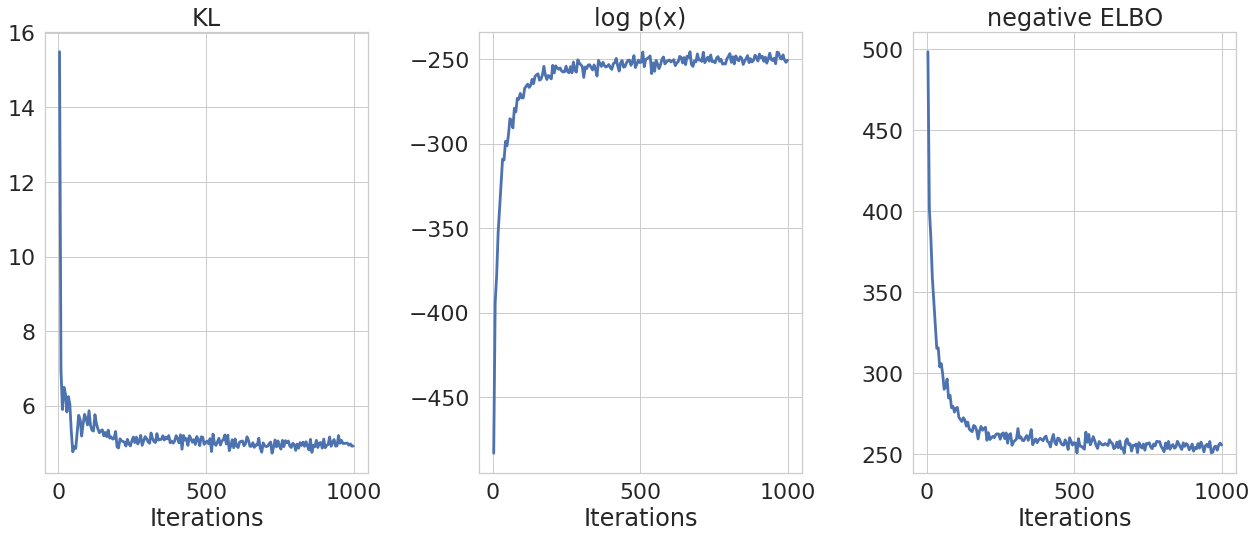

In [29]:
for step in range(TRAINING_STEPS):  
  params, prng_key, opt_state, stats = elbo_update(
      params, prng_key, opt_state, format_data(next(dataset)))

  elbo = stats[1]['elbo'].mean()
  kl = stats[1]['kl'].mean()
  log_p = stats[1]['log_p'].mean()

  if (step + 1) % PLOT_EVERY == 0:
    plot.update({
        'negative ELBO': -elbo,
        'kl': kl,
        'log_p': log_p
    }, current_step=step)
  if (step + 1) % PLOT_REFRESH_EVERY == 0:
    plot.send()
  
  losses.append(elbo)
  kls.append(kl)
  logps.append(log_p)

## Visualize reconstructions and samples




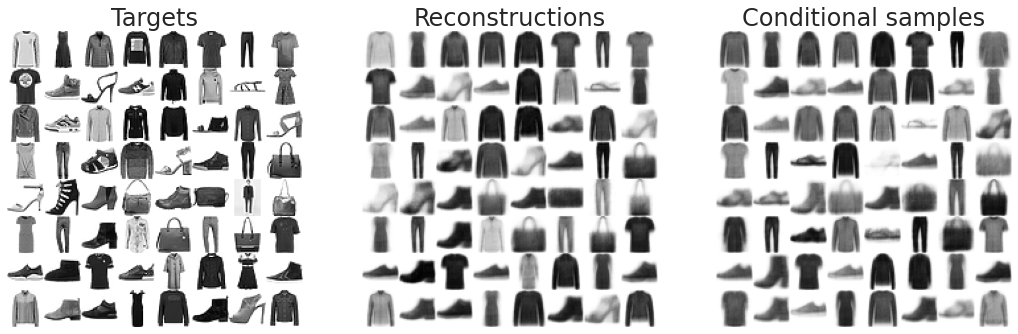

In [30]:
targets, reconstructions, samples = reconstruct_and_sample(
    params, prng_key, model,
    next(get_dataset(batch_size=VIS_BATCH_SIZE, num_dev=1, hard=USE_HARD_DATA,
                     data_split='test')))

sz = 6
_ = plt.figure(figsize=((3*sz, 1*sz)))
plt.subplot(131)
imshow(gallery(targets), 'Targets')
plt.subplot(132)
imshow(gallery(reconstructions), 'Reconstructions')
plt.subplot(133)
imshow(gallery(samples), 'Conditional samples');

## Explore the latent space



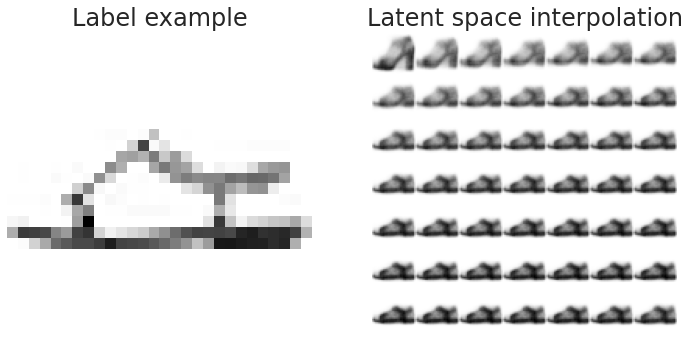

In [31]:
data = get_dummy_data(hard=USE_HARD_DATA)
num_steps = 7 * 7
samples_from_interpolations = get_latent_interpolations(
    model, get_slice(params), jax.random.PRNGKey(1), num_steps, data.context)

sz = 6
_ = plt.figure(figsize=((2*sz, sz)))
plt.subplot(121)
imshow(data.target[0,...], 'Label example')
plt.subplot(122)
imshow(gallery(samples_from_interpolations), 'Latent space interpolation')

# Training a VAE with KL annealing

Stochastic Variational Inference can get stuck in local optima since there is a certain tension between the likelihood and the KL terms. To ease the optimization, we could use a schedule fpr $\beta$ where the KL coefficient is slowly annealed from $0$ to $1$ throughout training. This corresponds to weight more the reconstruction term at the beginning of the training and then move towards the fully stochastic variational objective. The modified objective becomes: 

<font size=4>
<br>
<!-- $$ \mathcal{L}(X, z) = \mathbb{E}\big[\log P(X|z)\big] - D_{KL}\big[Q(z|X) \big|\big| P(z)\big].$$ -->

$$ \mathcal{L}(x|c) = - \Big( \mathbb{E}_{z \sim q(z|x, c)} \big[\log p_\theta(x | z, c)\big] - \beta \ \mathbb{KL}\big(q_\phi(z | x, c) || p(z|c)\big) \Big).$$
</font>

where the hyper-parameter $\beta$ is annealed throughout optimization.

**Tasks:**
- Modify the training objective with a linear KL annealing schedule.
- Look at the loss terms, what differences do you notice in their behaviours compared to the standard VAE objective?
- Look at the reconstructions and samples during training. What do you see?

</br>

For more information, see: 
* [Bowman et al, (2015), Generating Sentences from a Continuous Space, (Section 3.1)](https://arxiv.org/abs/1511.06349)
* [Sønderby et al, (2016), Ladder variational Autoencoder, (Section 2.3)](https://arxiv.org/abs/1602.02282)
* [Burgess et al, (2018), Understanding disentangling in β-VAE](https://arxiv.org/abs/1804.03599)



In [32]:
def get_beta_vae_loss_fn(model):  
  def beta_vae_loss_fn(params, prng, beta, data):
    _, loss_components = jax.tree_map(
        jnp.mean, model.stochastic_elbo(
            params, prng, data.target, data.context))
    # The beta-VAE training loss function is a function of the beta
    # hyper-parameter. Implement the loss using the components returned by 
    # the stochastic_elbo of the model class.
    # elbo_loss_fn
    # ADD CODE BELOW 
    # -------------------------------------------------------------  
    loss = beta * loss_components['kl'] - loss_components['log_p']
    # -------------------------------------------------------------  
    return loss, loss_components
  return beta_vae_loss_fn

In [33]:
prng_key = jax.random.PRNGKey(0)
params = model.init_params(prng_key, get_dummy_data(hard=USE_HARD_DATA))

beta_vae_loss_fn = get_beta_vae_loss_fn(model)

# Set up the optimzer and model like you did for the ELBO optimization
# ADD CODE BELOW 
# -------------------------------------------------------------  
beta_vae_optimizer = tx.adam(1e-2)
opt_state = beta_vae_optimizer.init(params)
params, prng_key, opt_state = setup_for_distributed_training(
    params, prng_key, opt_state, num_dev=NUM_DEV)
dataset = get_dataset(
    batch_size=BATCH_SIZE, num_dev=NUM_DEV, hard=USE_HARD_DATA)
  
def beta_vae_update(params, prng_key, opt_state, beta, data):  
  loss_key, prng_key = jax.random.split(prng_key)
  beta_vea_loss, grads = jax.value_and_grad(
      beta_vae_loss_fn, has_aux=True)(params, loss_key, beta, data)
  grads = jax.lax.pmean(grads, axis_name='i')
  raw_updates, opt_state = beta_vae_optimizer.update(grads, opt_state)
  params = tx.apply_updates(params, raw_updates)
  return params, prng_key, opt_state, beta_vea_loss
beta_vae_update = jax.pmap(
    beta_vae_update, axis_name='i', devices=jax.devices())
# -------------------------------------------------------------  


# During the optimization of the beta-VAE we will be scheduling the value of 
# beta. Use optax's polynomial schedule to set up a linear schedule, e.g.
# from 0.01 to 1.0 over TRAINING_STEPS//2 steps.
# ADD CODE BELOW 
# -------------------------------------------------------------  
beta_vae_current_step = 0
initial_beta, final_beta = 0.01, 1.0
beta_schedule = tx.polynomial_schedule(
    initial_beta, final_beta, power=1.0, transition_steps=TRAINING_STEPS//2)
# -------------------------------------------------------------  

beta_vae_losses = []
beta_vae_kls = []
beta_vae_logps = []

beta_vae_groups = {
  'log p(x)': ['log_p'], 
  'kl': ['kl'],
  'negative ELBO': ['negative ELBO'],
  'beta': ['beta']
}

beta_vae_plot = PlotLosses(
    groups=beta_vae_groups, 
    outputs=[MatplotlibPlot(max_cols=4, after_subplot=custom_after_subplot)], 
    step_names='Iterations')

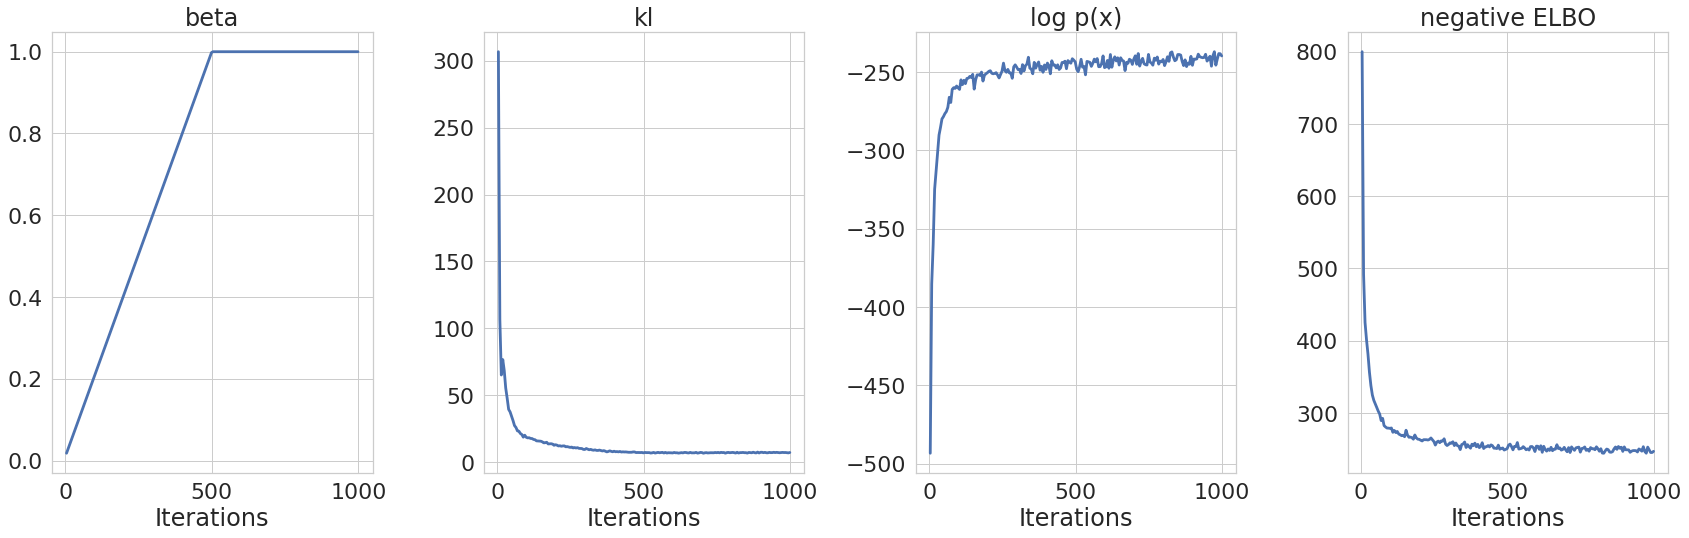

In [34]:
broadcast = lambda x: jnp.broadcast_to(x, (NUM_DEV,) + x.shape)

for _ in range(TRAINING_STEPS):
  beta_vae_current_step += 1
  beta = beta_schedule(beta_vae_current_step)
  # Since beta is varying during training, it cannot be statically compiled into
  # udpate function and needs to be broadcast prior to being passed to the 
  # beta_vae_update.
  params, prng_key, opt_state, stats = beta_vae_update(
      params, prng_key, opt_state, broadcast(beta), format_data(next(dataset)))
  
  elbo = stats[1]['elbo'].mean()
  kl = stats[1]['kl'].mean()
  log_p = stats[1]['log_p'].mean()

  if (beta_vae_current_step + 1) % PLOT_EVERY == 0:
    beta_vae_plot.update({
        'negative ELBO': -elbo,
        'kl': kl,
        'log_p': log_p,
        'beta': beta
    }, current_step=beta_vae_current_step)
  if beta_vae_current_step % PLOT_REFRESH_EVERY == 0:
    beta_vae_plot.send()
  
  beta_vae_losses.append(elbo)
  beta_vae_kls.append(kl)
  beta_vae_logps.append(log_p)

## Visualize reconstructions and samples

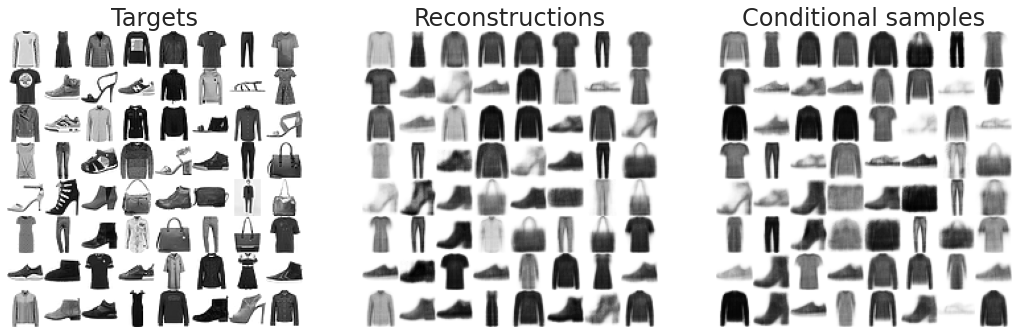

In [35]:
targets, reconstructions, samples = reconstruct_and_sample(
    params, prng_key, model,
    next(get_dataset(batch_size=VIS_BATCH_SIZE, num_dev=1, hard=USE_HARD_DATA,
                     data_split='test')))

sz = 6
_ = plt.figure(figsize=((3*sz, 1*sz)))
plt.subplot(131)
imshow(gallery(targets), 'Targets')
plt.subplot(132)
imshow(gallery(reconstructions), 'Reconstructions')
plt.subplot(133)
imshow(gallery(samples), 'Conditional samples');

## Explore the latent space


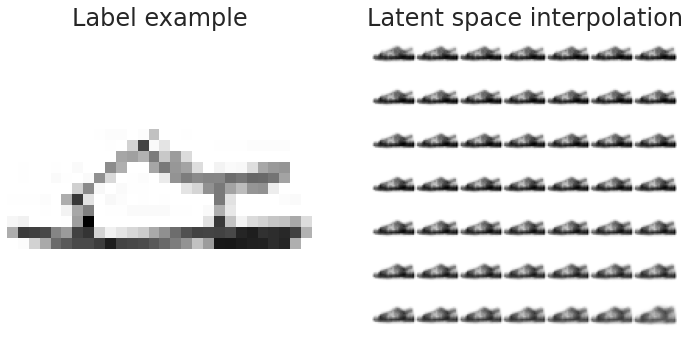

In [36]:
data = get_dummy_data(hard=USE_HARD_DATA)
num_steps = 7 * 7
samples_from_interpolations = get_latent_interpolations(
    model, get_slice(params), jax.random.PRNGKey(1), num_steps, data.context)

sz = 6
_ = plt.figure(figsize=((2*sz, sz)))
plt.subplot(121)
imshow(data.target[0,...], 'Label example')
plt.subplot(122)
imshow(gallery(samples_from_interpolations), 'Latent space interpolation')

# Constrained optimization

Constrained optimization can be used to dynamically tune the relative weight of the likelihood and KL terms during optimization. 
This removes the need to manually tune $\beta$, or create an optimization schedule, which can be problem specific.

The objective now becomes:

\begin{equation}
  \text{minimize } \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z)) \text{ such that }  \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x) \log p_\theta(x|z)} > \kappa 
\end{equation}

This can be solved using Lagrange multipliers. The objective then becomes:

\begin{equation}
  \text{minimize }  \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z)) + \lambda  (\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\kappa - \log p_\theta(x|z)))
\end{equation}


The difference compared to the KL annealing is that:

   * $\lambda$ is a learned parameter - it will be learned using stochastic gradient descent, like the network parameters.  The difference is that the lagrangian has to solve a maximization problem. You can see this intuitively: the graadient with respect to $\lambda$ in the objective above is $\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))$. If $ \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))> 0$, the constraint is not being satisfied, so the value of the lagrangian needs to increase. This will be done by doing gradient ascent, instead of gradient descent. Note that for $\lambda$ to be a valid lagranian in a minimization problem, it has to be positive.
   * The practicioner has to specify the hyperparameter $\kappa$, which determines the reoncstruction quality of the model.
   * the coefficient is in front of the likelihood term, not the KL term. This is mainly for convenience, as it is easier to specify the hyperparameter $\kappa$ for the likelihood (reconstruction loss).

For more assumptions made by this method, see the Karush–Kuhn–Tucker conditions.

For more information, see: 
  * http://bayesiandeeplearning.org/2018/papers/33.pdf


## Lagrange multipliers for constrained optimization

This is a reimplementation in JAX of the [constrained optimization tools](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/optimization_constraints.py) found in Sonnet v1.

Note the peculiar implementation of the `clip` function, which is used to limit the valid range of the multipliers; this is used for example to force their values to be non-negative, or to limit their maximum values to control the interaction of the loss components during training.

In this implementation the gradients flowing through the clipping function are not set to 0 when above and below the thresholds, if the gradients would make the inputs move towards the valid range. This is particularly useful when setting a maximum valid value, since it allows for the multipliers to become smaller once the constraints are (eventually) satisfied.

In [37]:
@functools.partial(jax.custom_vjp, nondiff_argnums=(1, 2, 3))
def clip(x, min_val, max_val, maximize=True):
  del maximize
  return jax.tree_map(lambda e: jnp.clip(e, min_val, max_val), x)


def clip_fwd(x, min_val, max_val, maximize):
  return clip(x, min_val, max_val, maximize), x


def clip_bwd(min_val, max_val, maximize, x, co_tangents):
  zeros = jax.tree_map(jnp.zeros_like, co_tangents)
  if min_val is not None:
    get_mask = lambda x, v, t: (x < v) & (t < 0 if maximize else t > 0)
    mask = jax.tree_multimap(get_mask, x, min_val, co_tangents)
    co_tangents = jax.tree_multimap(jnp.where, mask, zeros, co_tangents)
  if max_val is not None:
    get_mask = lambda x, v, t: (x > v) & (t > 0 if maximize else t < 0)
    mask = jax.tree_multimap(get_mask, x, max_val, co_tangents)
    co_tangents = jax.tree_multimap(jnp.where, mask, zeros, co_tangents)
  return co_tangents,


clip.defvjp(clip_fwd, clip_bwd)


class LagrangeMultiplier(hk.Module):
  """Lagrange Multiplier module for constrained optimization."""

  def __init__(self,
               shape=(),
               initializer=1.0,
               maximize=True,
               valid_range=None,
               name='lagrange_multiplier'):
    super().__init__(name=name)
    self._shape = shape
    if callable(initializer):
      self._initializer = initializer
    else:
      self._initializer = lambda *args: jnp.ones(*args) * initializer
    self._maximize = maximize
    self._valid_range = valid_range if valid_range is not None else (0.0, None)
    assert self._valid_range[0] >= 0

  def __call__(self):
    lag_mul = hk.get_parameter('w', self._shape, init=self._initializer)
    lag_mul = clip(lag_mul, *self._valid_range, maximize=self._maximize)
    return lag_mul

## Training a VAE using GECO

In [38]:
def get_geco_loss(prng, model, kappa, valid_range, init_lambda):

  def constraint_term(x, target):    
    lag_mul = LagrangeMultiplier(
        shape=x.shape, valid_range=valid_range, initializer=init_lambda)()
    return jnp.sum(lag_mul * (x - target)), lag_mul
  constraint_term = _transform(constraint_term)
  lagmul_params = constraint_term.init(prng, jnp.ones(()), jnp.ones(()))

  def geco_loss(params, prng, data):
    """Loss using constrained optimization as in GECO."""
    # Compute the KL term (make sure to average across the batch!)
    # ADD CODE BELOW 
    # -----------------------
    kl = jnp.mean(model.kl(params, prng, data.target, data.context))
    # -----------------------

    # Reconstruct the inputs and compute the reconstruction error (e.g. MSE)
    # ADD CODE BELOW 
    # -----------------------  
    reconstruction = model.reconstruct(params, prng, data.target, data.context)
    reconstruction_err = jnp.mean(_batch_sum((reconstruction - data.target)**2))
    # -----------------------

    # If you didn't use MSE before, you need to adjust the kappa term in the
    # constraint definition.
    constraint_satisfaction, lag_mul = constraint_term.apply(
        params, reconstruction_err, np.prod(data.target.shape[1:]) * kappa**2)
    loss = constraint_satisfaction + kl
    metrics = {
        'loss': loss, 
        'mse': jnp.mean((reconstruction - data.target)**2),
        'kl': kl,
        'lag_mul': lag_mul}
    return loss, metrics

  return geco_loss, lagmul_params

In [39]:
prng_key = jax.random.PRNGKey(0)
kappa = 0.18
valid_range = (0, 4.0)
init_lambda = 2.0

params = model.init_params(prng_key, get_dummy_data(hard=USE_HARD_DATA))
geco_loss_fn, lagmul_params = get_geco_loss(
    prng_key, model, kappa, valid_range, init_lambda=init_lambda)

## Using multiple optimizers jointly

We will now see how we can optimize joinlty the model parameters `params` and the Lagrange multipliers `lagmul_params`.

We want to update the Lagrange multipliers via stochastic gradient *ascent*; for example we could consider using the logic in `tx.sgd` with a *negative* learning rate. The model params will be instead optimized using ADAM, just like in the previous cells.

In the next cell you will find a handy wrapper to capture multiple optimizers into a single optax object. 

What is left to do is:

1.   Merge all the parameters into a single tree; you can do so using the `hk.data_structures.merge` utility in Haiku:

  ```
  params = hk.data_structures.merge(params, lagmul_params)
  ```
2.   Specify how to filter the resulting `params` structure to select which variables should be mapped to which optimizer. Tip: you can filter the Lagrange multipliers with:
  ```
  multiplier_filter = lambda m, n, p: 'lagrange' in m
  ```
  and the model variables with:
  ```
  model_params_filter = lambda m, n, p: 'lagrange' not in m
```

In [40]:
def multi_opt(**filter_optimizer_map):
  """Wraps multiple optimizers within an object with the optax interface.

  Args:
    **filter_optimizer_map: kwargs used to map optimizer names to
    (predicate, optimizer) tuples, where predicate is a function which will be
    passed to haiku.data_structure.filter in order to select which variables
    are to be updated by the corresponding optimizer.

  Returns:
    An optax.InitUpdate tuple.
  """
  def filter_(predicate, params):
    if params is None:
      return None
    return hk.data_structures.filter(predicate, params)

  merge_ = hk.data_structures.merge

  def _init(params):
    opt_state = dict()
    for opt_name, (predicate, opt) in filter_optimizer_map.items():
      opt_state[opt_name] = opt.init(filter_(predicate, params))
    return opt_state

  def _update(updates, state, params=None):
    new_updates = {}
    new_state = dict()
    for opt_name, (predicate, opt) in filter_optimizer_map.items():
      update, new_state[opt_name] = opt.update(
          filter_(predicate, updates), state[opt_name],
          filter_(predicate, params))
      new_updates = merge_(new_updates, update)
    return new_updates, new_state

  return tx.InitUpdate(_init, _update)

In [41]:
# Merge them using hk.data_structures.merge
# function.
# ADD CODE BELOW 
# -----------------------
params = hk.data_structures.merge(params, lagmul_params)
# -----------------------

# Optimize the Lagrange multipliers via stochastic gradient ascent.
# Optimize the model params will be optimized using ADAM.
# ADD CODE BELOW 
# -----------------------
geco_optimizer = multi_opt(
      lagmul_opt=(lambda m, n, p: 'lagrange' in m, tx.sgd(-2e-3)),
      model_opt=(lambda m, n, p: 'lagrange' not in m, tx.adam(1e-2)))
opt_state = geco_optimizer.init(params)
# -----------------------

params, prng_key, opt_state = setup_for_distributed_training(
    params, prng_key, opt_state, num_dev=NUM_DEV)

dataset = get_dataset(
    batch_size=BATCH_SIZE, num_dev=NUM_DEV, hard=USE_HARD_DATA)

def geco_update(params, prng_key, opt_state, data):
  loss_key, prng_key = jax.random.split(prng_key)
  geco_loss, grads = jax.value_and_grad(
      geco_loss_fn, has_aux=True)(params, loss_key, data)
  grads = jax.lax.pmean(grads, axis_name='i')
  raw_updates, opt_state = geco_optimizer.update(grads, opt_state)
  params = tx.apply_updates(params, raw_updates)
  return params, prng_key, opt_state, geco_loss
geco_update = jax.pmap(geco_update, axis_name='i', devices=jax.devices())

geco_current_step = 0
mses = []
kls = []
lag_muls = []

geco_groups = {
  'mse': ['mse'],
  'kl': ['kl'],
  'lag_mul': ['lag_mul'],
}

geco_plot = PlotLosses(
    groups=geco_groups,
    outputs=[MatplotlibPlot(max_cols=4, after_subplot=custom_after_subplot)], 
    step_names='Iterations')


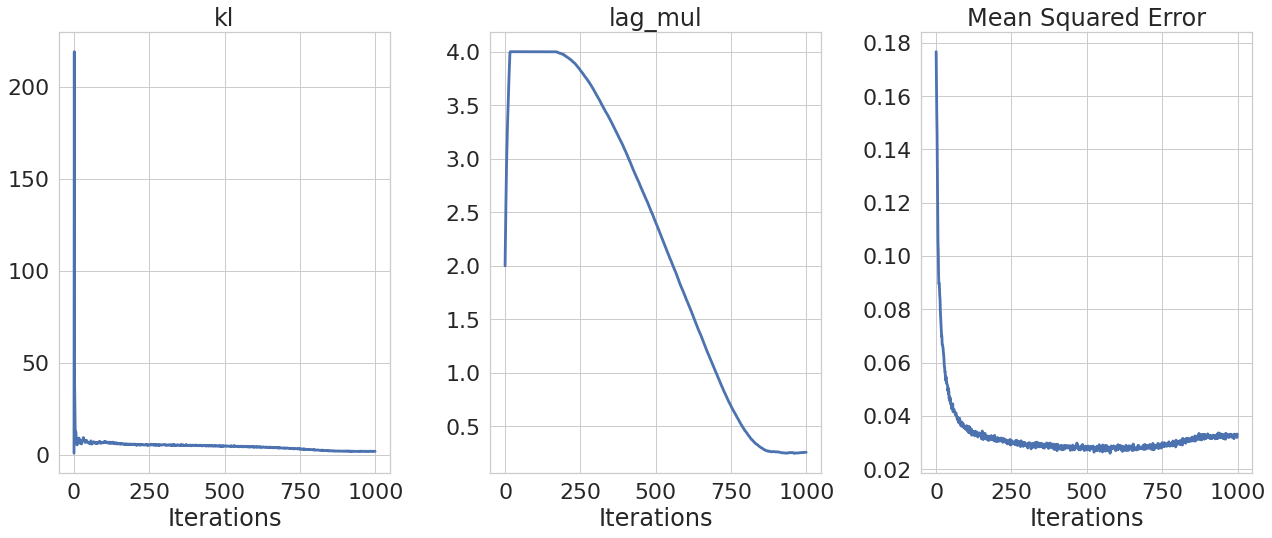

In [42]:
for _ in range(TRAINING_STEPS):
  geco_current_step += 1
  params, prng_key, opt_state, stats = geco_update(
      params, prng_key, opt_state, format_data(next(dataset)))
  mse = stats[1]['mse'].mean()
  kl = stats[1]['kl'].mean()
  lag_mul = stats[1]['lag_mul'].mean()

  geco_plot.update({
      'mse': mse,
      'kl': kl,
      'lag_mul': lag_mul
  })
  if geco_current_step % PLOT_REFRESH_EVERY == 0:
    geco_plot.send()
  
  mses.append(mse)
  kls.append(kl) 
  lag_muls.append(lag_mul)

## Visualize reconstructions and samples

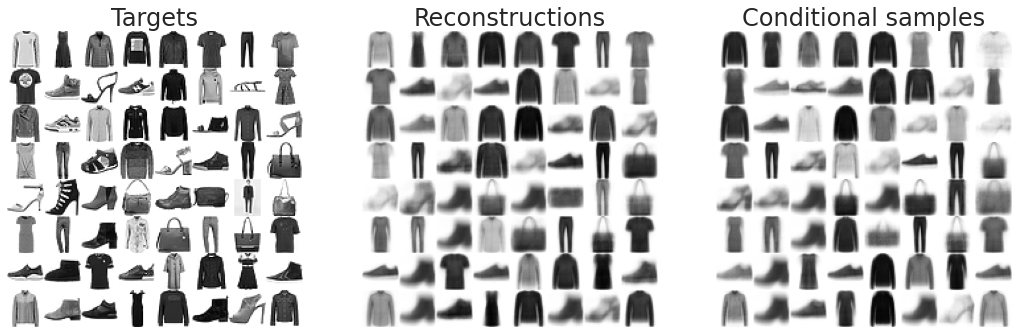

In [43]:
targets, reconstructions, samples = reconstruct_and_sample(
    params, prng_key, model,
    next(get_dataset(batch_size=VIS_BATCH_SIZE, num_dev=1, hard=USE_HARD_DATA,
                     data_split='test')))

sz = 6
_ = plt.figure(figsize=((3*sz, 1*sz)))
plt.subplot(131)
imshow(gallery(targets), 'Targets')
plt.subplot(132)
imshow(gallery(reconstructions), 'Reconstructions')
plt.subplot(133)
imshow(gallery(samples), 'Conditional samples');

## Explore the latent space

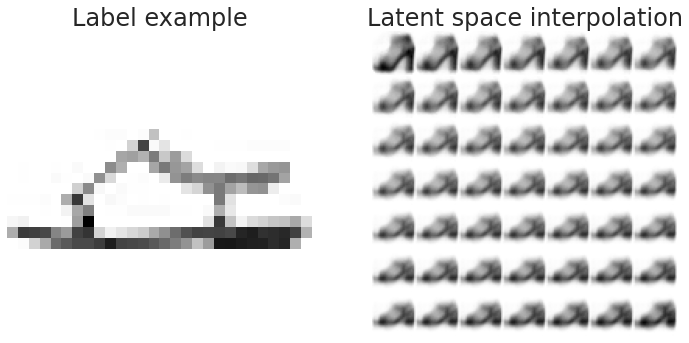

In [44]:
dummy_data = get_dummy_data(hard=USE_HARD_DATA)
num_steps = 7 * 7
samples_from_interpolations = get_latent_interpolations(
    model, get_slice(params), jax.random.PRNGKey(0), num_steps, dummy_data.context)

sz = 6
_ = plt.figure(figsize=((2*sz, sz)))
plt.subplot(121)
imshow(dummy_data.target[0,...], 'Label example')
plt.subplot(122)
imshow(gallery(samples_from_interpolations), 'Latent space interpolation')